In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from skimage.filters import threshold_otsu

from sfilter import sfilter

значение exp при j=k=0: (1+0j)


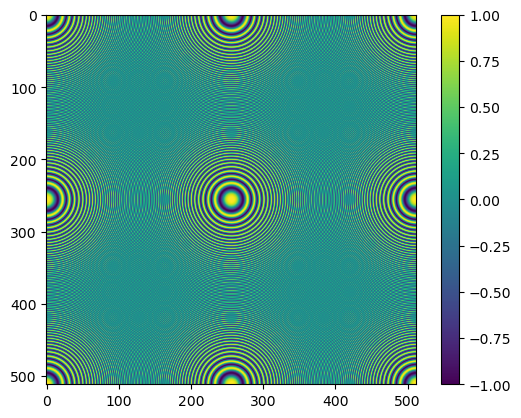

In [2]:
D = 2.5
Dpix = 228
nx = 512

f_scale = Dpix/(D*nx)
xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
fx = f_scale * xx 
fy = f_scale * yy

delta = D/Dpix

def exp(fx, fy, xx, yy, delta):
    i = 1j
    arg = -2*np.pi*i*delta*(xx*fx + yy*fy)
    return np.exp(arg)

plt.figure()
plt.imshow(np.real(exp(fx, fy, xx, yy, delta)))
plt.colorbar()

print('значение exp при j=k=0:', exp(fx, fy, xx, yy, delta)[256, 256])

In [3]:
np.seterr(all='ignore')
# ----------------------------- c_jk -----------------------------------

def c_jk(data): 
    nx = 512 # ширина окна для автокорреляции зрачка (должно быть минимум в 2 раза больше, чем ширина зрачка) 
    img = data
    data_pupil = np.pad(img, ((228 - img.shape[0], 0), (0, 228 - img.shape[1])), 'constant', constant_values=(0))
    I0c = (data_pupil != 0) * int(1)
    I0c = np.pad(I0c, ((nx - I0c.shape[0])//2, (nx - I0c.shape[1])//2), 'constant', constant_values=(0))
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(I0c)*np.fft.fft2(I0c).conjugate())))
    res /= np.max(res)
    
    return res

# ----------------------------- Монохроматическая гамма -----------------------------------

def gamma_mono(Cn2, D, D_pix, z, lambda_):
    nx = 512 # размер окна автокорреляции зрачка, должно быть в 2 раза больше чем размер зрачка
    
    const = 9.69*pow(10, -3)*16*pow(np.pi, 2) # константа перед интегралом 
        
    f_scale = D_pix/(D*nx) # шаг по частоте, [м^-1]
    delta = D/D_pix # шаг апертуры (соотношение между 1 пикселем и метрами, т.е. 1 пикс = 0.01 м) 

    xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
    fx = f_scale * xx 
    fy = f_scale * yy
    
    def gamma_mono_int(fx, fy, xx, yy, z, lambda_, delta): 
        def aperture_func(fx, fy, delta): 
            res = np.abs(np.sinc(delta*(-fx))*np.sinc(delta*(-fy)))**2
            return res
    
        def abs_f(fx, fy):
            res = pow(np.sqrt(fx**2+fy**2), -11./3.)
            res[np.isnan(res)] = 0
            return res

        def sin(fx, fy, z, lambda_): 
            res = pow(np.sin(np.pi*z*lambda_*(fx**2+fy**2)), 2) / pow(lambda_, 2)
            res[np.isnan(res)] = 0
            
            plt.imshow(res)
            plt.colorbar()
            plt.title('Фильтр Френеля')
            
            return res
        
#         def exp(fx, fy, xx, yy, delta):
#             i = 1j
#             arg = -2*np.pi*i*delta*(xx*fx + yy*fy)
#             return np.exp(arg)
            
    
        res = abs_f(fx, fy) * sin(fx, fy, z, lambda_) * aperture_func(fx, fy, delta)
        res[np.isnan(res)] = 0
    
        return np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(res))))
    
    return Cn2 * const * gamma_mono_int(fx, fy, xx, yy, z, lambda_, delta) * pow(f_scale, 2) * nx * nx

# ----------------------------- Полихроматическая гамма -----------------------------------

def gamma_poly(Cn2, D, D_pix, z):
    nx = 512 # размер окна автокорреляции зрачка, должно быть в 2 раза больше чем размер зрачка
    
    const = 9.69*pow(10, -3)*16*pow(np.pi, 2) # константа перед интегралом 
        
    f_scale = D_pix/(D*nx) # шаг по частоте, [м^-1]
    delta = D/D_pix # шаг апертуры (соотношение между 1 пикселем и метрами, т.е. 1 пикс = 0.01 м) 

    xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
    fx = f_scale * xx 
    fy = f_scale * yy
    
    def gamma_poly_int(fx, fy, xx, yy, z, lambda_, delta): 
        def aperture_func(fx, fy, delta): 
            res = np.abs(np.sinc(delta*(-fx))*np.sinc(delta*(-fy)))**2
            return res
    
        def abs_f(fx, fy):
            res = pow(np.sqrt(fx**2+fy**2), -11./3.)
            res[np.isnan(res)] = 0
            return res
        
        S = sfilter(D=D, D_pix=D_pix, z=z)

        
#         def exp(fx, fy, xx, yy, delta):
#             i = 1j
#             arg = -2*np.pi*i*delta*(xx*fx + yy*fy)
#             return np.exp(arg)
            
    
        res = abs_f(fx, fy) * S * aperture_func(fx, fy, delta)
        res[np.isnan(res)] = 0
    
        return np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(res))))
    
    return Cn2 * const * gamma_poly_int(fx, fy, xx, yy, z, lambda_, delta) * pow(f_scale, 2) * nx * nx
 
# ----------------------------- Корреляция -----------------------------------

def correlate(data, latency): 
    correlation = np.zeros_like(data)
    def correlate_fft(img1, img2):
        corr = np.fft.fftshift(np.abs(np.fft.ifft2(np.fft.fft2(img1)*np.fft.fft2(img2).conjugate()))) # np.real; np.abs
        corr /= np.max(corr)
        return corr
    
    for i in range(data.shape[0] - latency):
        correlation[i] = correlate_fft(data[i], data[i + latency])
    
    return np.mean(correlation, axis=0)
    
# ----------------------------- Получение изображения зрачка -----------------------------------

def pupil(data):  
    image_average = np.mean(data, axis=0) # средний кадр серии
    image_binary = (image_average > threshold_otsu(image_average)) * int(255) # маска среднего кадра
    
    def image_normalize(data): # нормировка потока, <I> = 0
        return (data)/(image_average) - 1

    def image_mask(data): # вырез зрачка
        return image_normalize(data) * image_binary

    def image_square_cropp(data): # обрезка зрачка в квадрат
        mask = image_mask(data)[0] != 0
        rows = np.flatnonzero((mask.any(axis=1))) 
        cols = np.flatnonzero((mask.any(axis=0)))
        squared = image_mask(data)[:, rows.min():rows.max()+1, cols.min():cols.max()+1] 
        return squared 
    
    return image_square_cropp(data)   

# ----------------------------- Отрисовка скорости ветра и турбулентных пятен -----------------------------------

def draw_correlate_with_velocity(data, D, latency, frames_per_sec): 
    def v(D, img, latency, frames_per_sec):
        return (D / img.shape[1]) / (latency * frames_per_sec)
    
    img = data.copy()
    x = np.round(v(D, img, latency, frames_per_sec)*np.linspace(-img.shape[0]//2, img.shape[0]//2, 5), 2)
    fig = plt.figure()
    ax = plt.axes()
    im = plt.imshow(img, cmap = None)
    ax.set_xticks(np.linspace(0, img.shape[1], 5))
    ax.set_yticks(np.linspace(0, img.shape[0], 5))
    ax.set_xticklabels(x, fontsize=12)
    ax.set_yticklabels(x, fontsize=12)
    ax.set_ylabel('Vy, m/s', fontsize=12)
    ax.set_xlabel('Vx, m/s', fontsize=12)
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)
    ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

In [4]:
# ----------------------------- Inputs -----------------------------------
file = '20210130l_m2km.fits'      # файл с объектом
file_bias = 'bias20210130.fits'   # файл с кадром смещения, bias
latency = 4                       # задержка в кросс-корреляции
D = 2.5                           # диаметр телескопа, [м]
lambda_ = 500 * pow(10, -9)       # длина волны, [м]
z = 2000                          # дистанция распространения, [м]
D_pix = 228                       # диаметр телескопа, [пиксели]

cmap = None                       # Цвет отрисовки

Filename: C:\Users\miron\coding\DomecamDraft\bias20210130.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 1000)   int16 (rescales to uint16)   
Filename: C:\Users\miron\coding\DomecamDraft\20210130l_m2km.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 6000)   int16 (rescales to uint16)   
 
time: 145.87332229999998


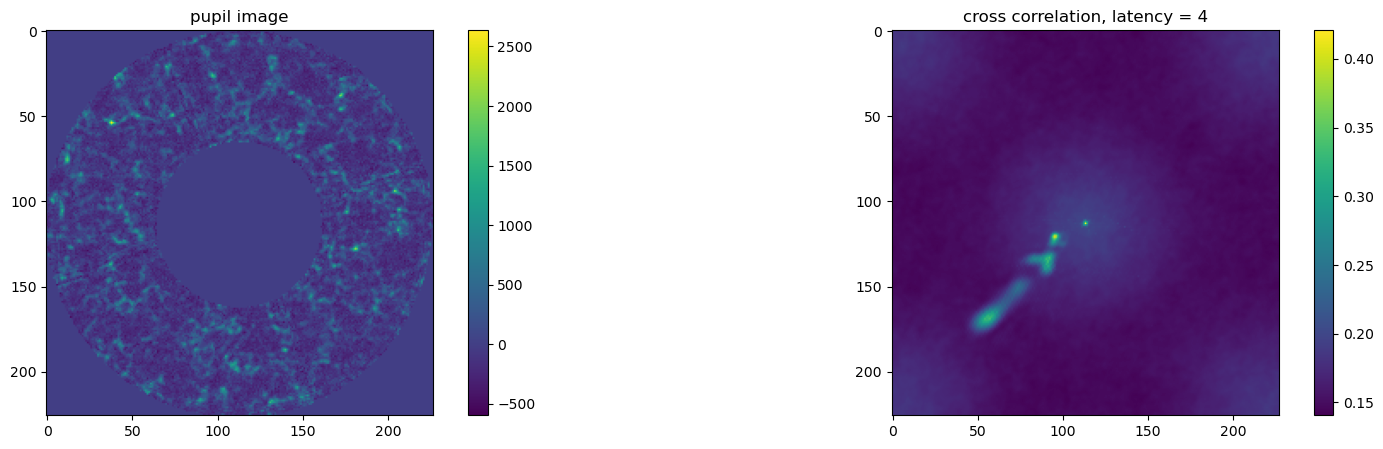

In [5]:
st = time.perf_counter()
with fits.open(os.path.abspath(file_bias)) as f:
    f.info()
    bias = np.mean(f[0].data.astype(np.float32), axis=0)
    
with fits.open(os.path.abspath(file)) as f:
    f.info()
    frames_per_sec = 1 / f[0].header['FRATE']
    header = f[0].header
    data = np.float32(f[0].data) - bias 
    
data = pupil(data)    
data_corr = correlate(data, latency)

fig, (ax_img, ax_img2) = plt.subplots(1, 2, figsize=(20, 5))

fig.colorbar(ax_img.imshow(data[0], cmap=cmap), ax = ax_img)
ax_img.set_title('pupil image')
ax_img.grid(False)

fig.colorbar(ax_img2.imshow(data_corr, cmap=cmap), ax = ax_img2)
ax_img2.set_title(f'cross correlation, latency = {latency}')
ax_img2.grid(False)

print(' ')
print('time:', time.perf_counter()-st)

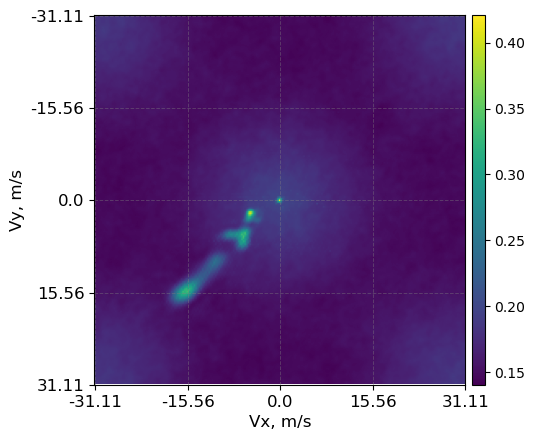

In [6]:
draw_correlate_with_velocity(data_corr, D, latency, frames_per_sec)

Cn2_ex: 6.826590771729513e-13
Cn2: 2.1685316923824695e-12


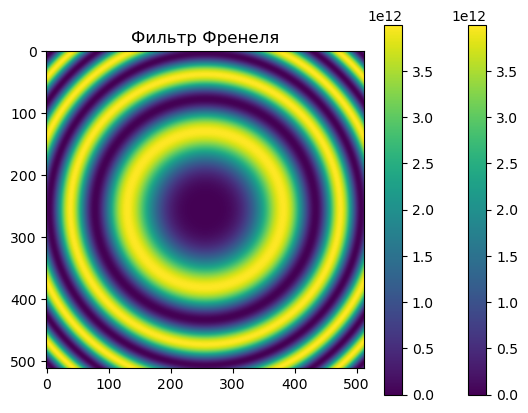

In [7]:
'''
Ex:

Для примера пусть Cn2 соответствует качеству изображения, равному 1 угловой секунде (типичное качество изображения) на длине 
волны 500 нм. Для удобства величину Cn2(z)dz рассматриваем как одну величину, обозначим ее C. Тогда:
    beta = 0.98 * lambda/r0 = 1, следовательно: r0 = 0.98*lambda*206265,
Пусть мы наблюдаем в зените, тогда параметр Фрида будет:
    r0 = (0.423*k^2 * C)^(-3/5), где k = 2*pi/lambda.
Далее можно просто выразить и посчитать С
'''
Cn2_ex = pow((0.98*lambda_)*206265, -5/3) / (0.423*pow(2*np.pi/lambda_, 2))

n = 10 # полуширина центрального окна в кросс-корреляции                                                                          
k = np.max(data_corr[data_corr.shape[0]//2-n:data_corr.shape[0]//2+n, data_corr.shape[1]//2-n:data_corr.shape[1]//2+n]) \
    / (gamma_mono(Cn2_ex, D, D_pix, z, lambda_) * c_jk(data[0]))[256, 256]
Cn2 = Cn2_ex * k 
gamma_new = gamma_mono(Cn2, D, D_pix, z, lambda_) * c_jk(data[0])

print('Cn2_ex:', Cn2_ex)
print('Cn2:', Cn2)

Text(0.5, 0.98, 'Монохроматический случай')

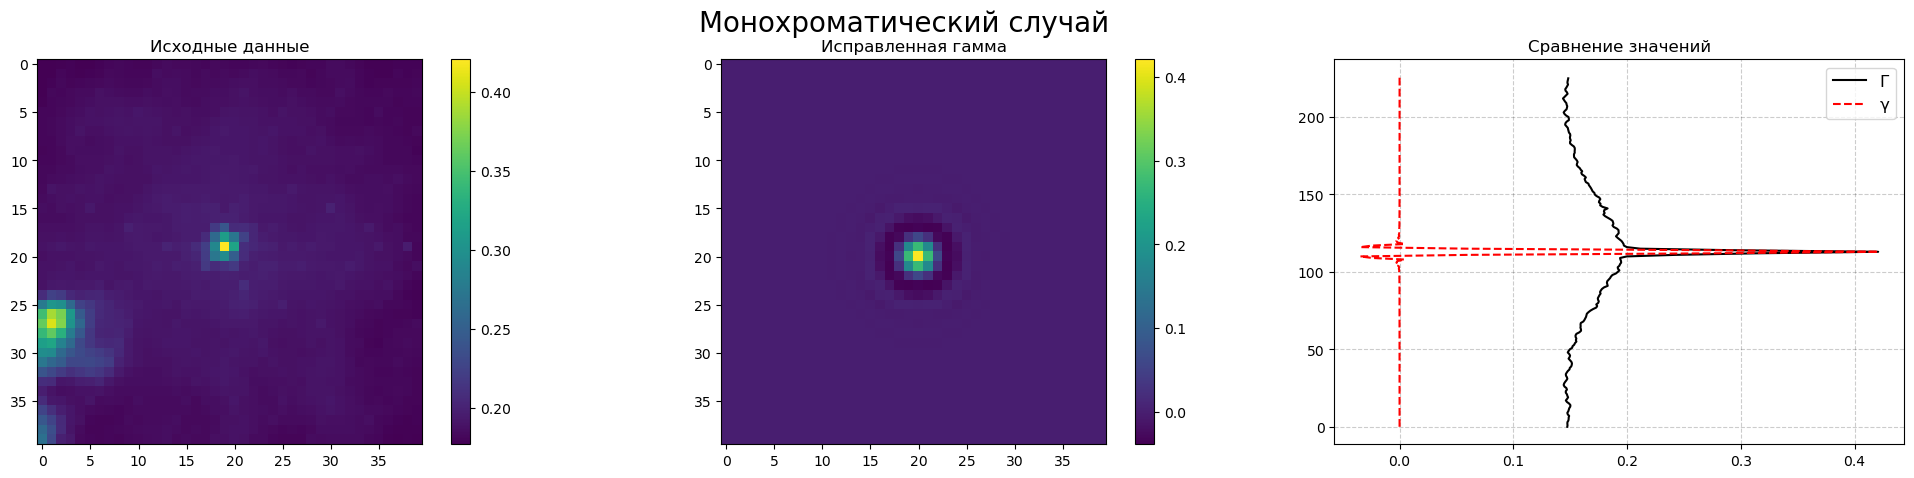

In [8]:
X = data_corr[:, 113]
Y = range(226)
X3 = gamma_new[143:370, 256]
Y3 = range(227)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

fig.colorbar(ax.imshow(data_corr[94:134, 94:134], cmap=cmap), ax = ax)
ax.grid(False)
ax.set_title('Исходные данные')

fig.colorbar(ax2.imshow(gamma_new[236:276, 236:276], cmap=cmap), ax=ax2)
ax2.grid(False)
ax2.set_title('Исправленная гамма')

ax3.plot(X, Y, alpha = 1, label = 'original corr', color = 'black')
ax3.plot(X3, Y3, alpha = 1, ls = '--', label = 'corected gamma', color = 'red')
ax3.legend(['Γ', 'γ'], loc=1, prop={'size': 12})
ax3.grid(color = 'black', linestyle='--', alpha = 0.2)
ax3.set_title('Сравнение значений')

# fig.savefig('C:/astro/teor_corr2.png', bbox_inches='tight')
fig.suptitle('Монохроматический случай', fontsize=20)

In [11]:
Cn2_ex = 1 * pow(10, -13)

n = 10 # полуширина центрального окна в кросс-корреляции                                                                          
k = np.max(data_corr[data_corr.shape[0]//2-n:data_corr.shape[0]//2+n, data_corr.shape[1]//2-n:data_corr.shape[1]//2+n]) \
    / (gamma_poly(Cn2_ex, D, D_pix, z) * c_jk(data[0]))[256, 256]
Cn2 = Cn2_ex * k 
gamma_new = gamma_poly(Cn2, D, D_pix, z) * c_jk(data[0])

print('Cn2_ex:', Cn2_ex)
print('Cn2:', Cn2)

Cn2_ex: 1e-13
Cn2: 4.4442993240488295e-12


Text(0.5, 0.98, 'Полихроматический случай')

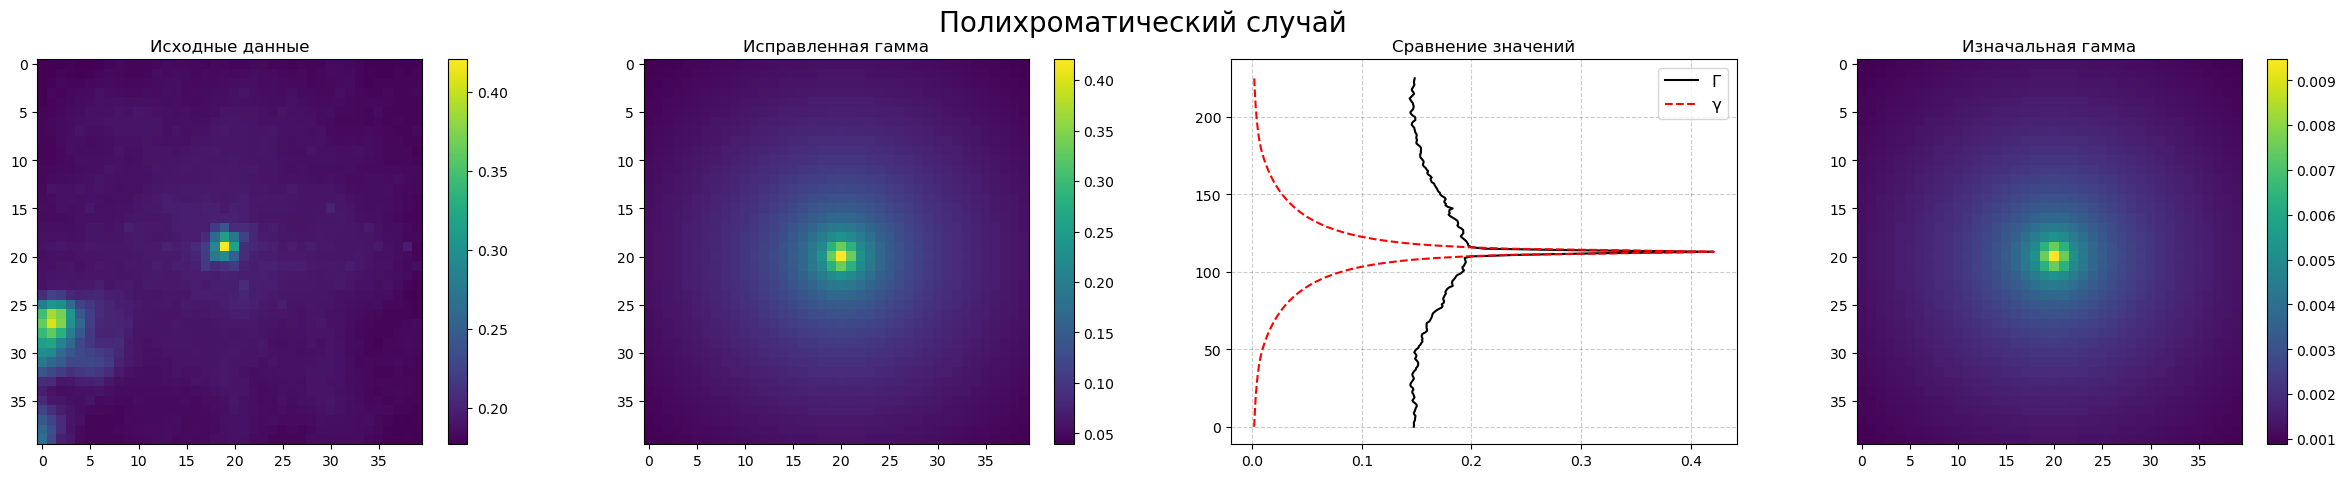

In [10]:
X = data_corr[:, 113]
Y = range(226)
X3 = (gamma_poly(Cn2_ex, D, D_pix, z) * c_jk(data[0]))[143:370, 256]
Y3 = range(227)
X3 = gamma_new[143:370, 256]
Y3 = range(227)

fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

fig.colorbar(ax.imshow(data_corr[94:134, 94:134], cmap=cmap), ax = ax)
ax.grid(False)
ax.set_title('Исходные данные')

fig.colorbar(ax2.imshow(gamma_new[236:276, 236:276], cmap=cmap), ax=ax2)
ax2.grid(False)
ax2.set_title('Исправленная гамма')

ax3.plot(X, Y, alpha = 1, label = 'original corr', color = 'black')
ax3.plot(X3, Y3, alpha = 1, ls = '--', label = 'corected gamma', color = 'red')
ax3.legend(['Γ', 'γ'], loc=1, prop={'size': 12})
ax3.grid(color = 'black', linestyle='--', alpha = 0.2)
ax3.set_title('Сравнение значений')

fig.colorbar(ax4.imshow((gamma_poly(Cn2_ex, D, D_pix, z) * c_jk(data[0]))[236:276, 236:276], cmap=cmap), ax=ax4)
ax4.grid(False)
ax4.set_title('Изначальная гамма')

fig.savefig('C:/astro/abs_corr_polychromatic.png', bbox_inches='tight')
fig.suptitle('Полихроматический случай', fontsize=20)